
# End-to-End Machine Learning Project

El objetivo de este notebook es usar el dataset California census data para construir un modelo capaz de predecir el precio de las casas en el estado.

Estos datos incluyen métricas como la población, el ingreso medio y el precio medio de la vivienda para cada grupo de manzanas de California. Los grupos de manzanas son la unidad geográfica más pequeña para la que la Oficina del Censo de EE. UU. publica datos de muestra (un grupo de manzanas suele tener una población de entre 600 y 3000 personas). Los llamaremos "distritos" para abreviar.

Claro que los datos no son recientes son de 1990, pero supondremos que son actuales.

El libro ofrece una lista en su apendice para poder guiarnos en la realización de cada proyecto de Machine Learning, esto es solo una guía y nosotros debemos de ser capaces de adaptarlo  nuestras necesidades.

La guía se encuentra en el notebook llamado Apendice_A de este directorio.

# Enmarcar el problema

Tal como dice la guía empezaremos con enmarcar el problema

La primera pregunta que debemos de hacer a nuestro jefe es ¿cuál es exactamente el objetivo empresarial?,¿Cómo espera la empresa utilizar y beneficiarse de este modelo? Conocer el objetivo es importante porque determinará cómo plantear el problema, qué algoritmos seleccionar, qué medida de rendimiento utilizará para evaluar su modelo y cuánto esfuerzo dedicará a ajustarlo.

Supongamos que las respuestas son que el resultado del modelo (una predicción del precio medio de la vivienda de un distrito) se incorporará a otro sistema de aprendizaje automático (véase la [Figura 1](#imagen-1)), junto con muchas otras señales. Este sistema determinará si vale la pena invertir en una zona determinada. Acertar con esto es fundamental, ya que afecta directamente a los ingresos.

La siguiente pregunta que debemos hacerle al jefe es, ¿cuál es la solución actual (si la hay)?. La situación actual a menudo proporciona una referencia del rendimiento, así como información sobre cómo resolver el problema. El jefe responde que actualmente los precios de la vivienda del distrito son estimados manualmente por expertos: un equipo recopila información actualizada sobre un distrito y, cuando no pueden obtener el precio medio de la vivienda, lo estiman utilizando reglas complejas.

## Figura 1: Un pipeline de aprendizaje automático para inversiones inmobiliarias
<a id="imagen-1"></a>
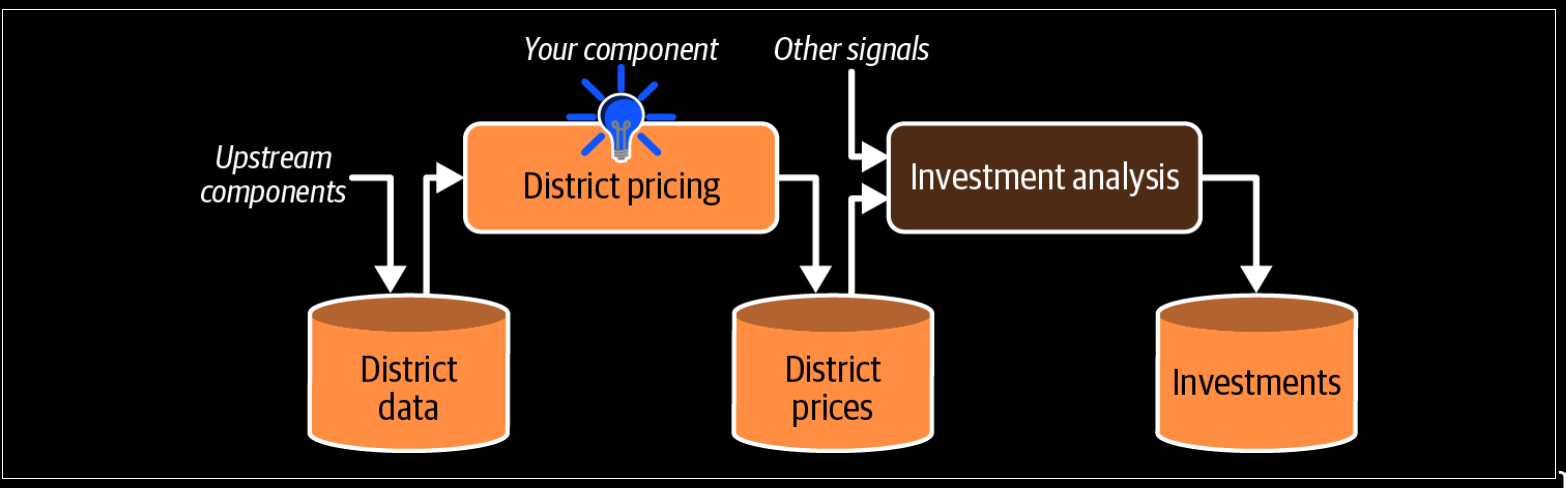

Esto es costoso y requiere mucho tiempo, y sus estimaciones no son muy precisas; en los casos en que logran averiguar el precio medio real de la vivienda, a menudo se dan cuenta de que sus estimaciones estaban equivocadas en más de un 30 %. Por eso, la empresa considera útil entrenar un modelo para predecir el precio medio de la vivienda de un distrito, a partir de otros datos sobre dicho distrito. Los datos del censo parecen ser un excelente conjunto de datos para este propósito, ya que incluyen los precios medios de la vivienda de miles de distritos, así como otros datos.

## ¿Qué es un Pipile?
Una secuencia de componentes de procesamiento de datos se denomina un data pipeline. Los Pipelines son muy comunes en los sistemas de aprendizaje automático, ya que hay una gran cantidad de datos que manipular y muchas transformaciones de datos que aplicar.

Los componentes suelen ejecutarse de forma asíncrona. Cada componente toma una gran cantidad de datos, los procesa y produce el resultado en otro almacén de datos. Luego, algún tiempo después, el siguiente componente del pipeline toma esos datos y genera su propia salida.

Cada componente es bastante autónomo: la interfaz entre los componentes es simplemente el almacén de datos. Esto hace que el sistema sea sencillo de comprender (con la ayuda de un grafo de flujo de datos), y permite que distintos equipos se centren en componentes diferentes.

Además, si un componente falla, los componentes aguas abajo a menudo pueden seguir funcionando con normalidad (al menos durante un tiempo) simplemente utilizando la última salida del componente que falló. Esto hace que la arquitectura sea bastante robusta.

Por otro lado, un componente defectuoso puede pasar desapercibido durante algún tiempo si no se implementa una monitorización adecuada. Los datos se vuelven obsoletos y el rendimiento general del sistema disminuye.

Con toda esta información, ya está listo para empezar a diseñar su sistema. Primero, determine qué tipo de supervisión de entrenamiento necesitará el modelo: ¿se trata de una tarea de aprendizaje supervisado, no supervisado, semisupervisado, autosupervisado o de refuerzo? ¿Y es una tarea de clasificación, de regresión o algo más? ¿Debería utilizar técnicas de aprendizaje por lotes o en línea? Antes de continuar, deténgase e intente responder estas preguntas.

¿Ha encontrado las respuestas? Veamos. Esta es claramente una tarea típica de aprendizaje supervisado, ya que el modelo se puede entrenar con ejemplos etiquetados (cada instancia incluye el resultado esperado, es decir, el precio medio de la vivienda del distrito). Es una tarea típica de regresión, ya que se le pedirá al modelo que prediga un valor. Más específicamente, se trata de un problema de regresión múltiple, ya que el sistema utilizará múltiples características para realizar una predicción (la población del distrito, la mediana de ingresos, etc.). También es un problema de regresión univariante, ya que solo intentamos predecir un valor único para cada distrito. Si intentáramos predecir múltiples valores por distrito, sería un problema de regresión multivariante. Finalmente, no hay un flujo continuo de datos que ingresan al sistema, no hay necesidad de ajustarse a datos cambiantes rápidamente y los datos son lo suficientemente pequeños como para caber en la memoria, por lo que el aprendizaje por lotes simple debería ser suficiente.

# Seleccionar una medida de rendimiento

El siguiente paso es seleccionar una medida de rendimiento. Una medida de rendimiento típica para problemas de regresión es el error cuadrático medio (RMSE). Este da una idea del grado de error que suele cometer el sistema en sus predicciones, otorgando mayor importancia a los errores grandes. La fórmula matemática para calcular el RMSE es:

$$RMSE(\mathbf{X},h) = \sqrt{\frac{1}{m} \sum_{i=1}^{m} (h(\mathbf{x}^{(i)}) - y^{(i)})^2}$$


## Notaciones

Esta sección introduce varias notaciones de machine learning muy comunes que se utilizarán a lo largo de este libro:

* $m$ es el número de instancias en el conjunto de datos sobre el cual se está midiendo el RMSE. Por ejemplo, si estás evaluando el RMSE en un conjunto de validación de 2,000 distritos, entonces $m = 2,000$.
* $\mathbf{x}^{(i)}$ es un vector con todos los valores de las características (excluyendo la etiqueta) de la $i$-ésima instancia en el conjunto de datos, y $y^{(i)}$ es su etiqueta (el valor de salida deseado para esa instancia).

Por ejemplo, si el primer distrito en el conjunto de datos está ubicado en la longitud $-118.29^\circ$, latitud $33.91^\circ$, y tiene 1,416 habitantes con un ingreso medio de $\$38,372$, y el valor medio de la vivienda es $\$156,400$ (ignorando otras características por ahora), entonces:

$$
\mathbf{x}^{(1)} = \begin{pmatrix} -118.29 \\ 33.91 \\ 1.416 \\ 38.372 \end{pmatrix}
$$

y:

$$
y^{(1)} = 156,400
$$

* $\mathbf{X}$ es una matriz que contiene todos los valores de las características (excluyendo las etiquetas) de todas las instancias en el conjunto de datos. Hay una fila por instancia, y la $i$-ésima fila es igual a la transpuesta de $\mathbf{x}^{(i)}$, denotada como $(\mathbf{x}^{(i)})^\top$.

Por ejemplo, si el primer distrito es como se acaba de describir, entonces la matriz $\mathbf{X}$ se vería así:

$$
\mathbf{X} = \begin{pmatrix} (\mathbf{x}^{(1)})^\top \\ (\mathbf{x}^{(2)})^\top \\ \vdots \\ (\mathbf{x}^{(1999)})^\top \\ (\mathbf{x}^{(2000)})^\top \end{pmatrix} = \begin{pmatrix} -118.29 & 33.91 & 1.416 & 38.372 \\ \vdots & \vdots & \vdots & \vdots \end{pmatrix}
$$

* $h$ es la función de predicción de tu sistema, también llamada hipótesis. Cuando a tu sistema se le da el vector de características de una instancia $\mathbf{x}^{(i)}$, este genera un valor predicho $\hat{y}^{(i)} = h(\mathbf{x}^{(i)})$ para esa instancia.

Por ejemplo, si tu sistema predice que el precio medio de la vivienda en el primer distrito es de $\$158,400$, entonces $\hat{y}^{(1)} = h(\mathbf{x}^{(1)}) = 158,400$. El error de predicción para este distrito es $\hat{y}^{(1)} - y^{(1)} = 2,000$.

* $RMSE(\mathbf{X}, h)$ es la función de costo medida en el conjunto de ejemplos utilizando tu hipótesis $h$.

Utilizamos fuente minúscula en cursiva para valores escalares (como $m$ o $y^{(i)}$) y nombres de funciones (como $h$), fuente minúscula en negrita para vectores (como $\mathbf{x}^{(i)}$), y fuente mayúscula en negrita para matrices (como $\mathbf{X}$).

### Otras Medidas de Rendimiento: Error Absoluto Medio (MAE)

Aunque el RMSE es generalmente la medida de rendimiento preferida para las tareas de regresión, en algunos contextos podrías preferir usar otra función. Por ejemplo, si hay muchos distritos que son valores atípicos. En ese caso, puedes considerar usar el error absoluto medio (MAE, por sus siglas en inglés, también llamado desviación absoluta promedio), que se muestra a continuación:

$$
MAE(\mathbf{X}, h) = \frac{1}{m} \sum_{i=1}^{m} \left| h(\mathbf{x}^{(i)}) - y^{(i)} \right|
$$


### Medidas de Distancia (Normas)

Tanto el RMSE como el MAE son formas de medir la distancia entre dos vectores: el vector de predicciones y el vector de valores objetivo. Varias medidas de distancia, o normas, son posibles:

* Calcular la raíz de una suma de cuadrados (RMSE) corresponde a la norma Euclidiana: esta es la noción de distancia con la que todos estamos familiarizados. También se le llama la norma $\ell_2$, denotada como $\|\cdot\|_2$ (o simplemente $\|\cdot\|$).
* Calcular la suma de valores absolutos (MAE) corresponde a la norma $\ell_1$, denotada como $\|\cdot\|_1$. A veces se le llama la norma de Manhattan porque mide la distancia entre dos puntos en una ciudad si solo puedes viajar a lo largo de manzanas de la ciudad de forma ortogonal.
* De manera más general, la norma $\ell_k$ de un vector $\mathbf{v}$ que contiene $n$ elementos se define como:

$$
\|\mathbf{v}\|_k = \left( |v_1|^k + |v_2|^k + \dots + |v_n|^k \right)^{\frac{1}{k}}
$$

* $\ell_0$ da el número de elementos no nulos en el vector, y $\ell_\infty$ da el valor absoluto máximo en el vector.

Cuanto mayor sea el índice de la norma, más se enfoca en los valores grandes y descuida los pequeños. Es por esto que el RMSE es más sensible a los valores atípicos que el MAE. Pero cuando los valores atípicos son exponencialmente raros (como en una curva en forma de campana), el RMSE funciona muy bien y es generalmente el preferido.

# Comprueba los supuestos

Por último, es recomendable enumerar y verificar las suposiciones realizadas hasta el momento (por usted o por otros); esto puede ayudarle a detectar problemas graves a tiempo. Por ejemplo, los precios por distrito que genera su sistema se introducirán en un sistema de aprendizaje automático posterior, y usted asume que estos precios se utilizarán como tales. Pero ¿qué ocurre si el sistema posterior convierte los precios en categorías (por ejemplo, "barato", "medio" o "caro") y luego utiliza esas categorías en lugar de los propios precios? En este caso, obtener el precio perfecto no es importante en absoluto; su sistema solo necesita obtener la categoría correcta. Si es así, el problema debería haberse planteado como una tarea de clasificación, no de regresión. No querrá descubrir esto después de trabajar en un sistema de regresión durante meses. 

Afortunadamente, después de hablar con el equipo a cargo del sistema posterior, está seguro de que realmente necesitan los precios reales, no solo las categorías. ¡Genial! ¡Ya está todo listo, las luces están en verde y puedes empezar a programar ahora mismo!

# Descargando los datos

In [1]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)
    with tarfile.open(tarball_path) as housing_tarball:
            housing_tarball.extractall(path="datasets")
    return pd.read_csv(Path("datasets/housing/housing.csv"))

housing = load_housing_data()

In [2]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB
